# **Sentiment Analysis of Twitter Feedback on Apple and Google Products Using Natural Language Processing**

## 1.	Business Understanding
### Business Problem

The objective of this project is to develop an automated sentiment analysis system that classifies public opinion about Apple and Google products using Twitter data. Organizations rely on real-time feedback from social media to understand customer satisfaction, identify emerging issues, and inform product or marketing decisions. Manual review of tweets is slow, inconsistent, and not scalable; therefore, an automated NLP model is required.

### Project Objectives
• Build a supervised machine learning model capable of classifying tweets as positive, negative, or neutral.\
• Provide a proof-of-concept system that can support automated monitoring of brand sentiment.\
• Demonstrate an effective NLP workflow, including data preparation, feature extraction, model training, and evaluation.\
• Ensure the model generalizes well to unseen tweets through appropriate validation.

### Success Metrics
• Accuracy to measure overall performance.\
• F1-score to account for class imbalance and evaluate model reliability.\
• Precision and Recall, especially for negative sentiment, which is often the most actionable for stakeholders.\
• Consistent performance across training and test sets to ensure generalization.

### Constraints
• The dataset is relatively small, limiting the complexity of the modeling approach.\
• Tweets contain informal writing, noise, and inconsistent formatting.\
• Processing and modeling must be done using local computational resources.\
• Project timelines require efficient methods and reproducible workflows.

## 2. Data Understanding
### Dataset Description
The dataset consists of approximately 9,000 tweets from CrowdFlower/data.world, each labeled by human annotators as positive, negative, or neutral. Each entry includes the raw tweet text and its associated sentiment class. The data originates from real Twitter activity and therefore reflects natural and unstructured language.

In [12]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re



#load Data
df = pd.read_csv(r"crowdflower_twitter_sentiment.csv", encoding='latin1')

#Display first six rows
df.head(6)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product


### Exploratory Data Analysis (EDA)
Before building a sentiment classification model, it is essential to understand the structure, quality, and characteristics of the dataset. Exploratory Data Analysis (EDA) provides insights into the patterns and challenges present in the raw tweets and helps determine the most effective preprocessing and modeling strategies.

Our EDA focuses on four key areas:

#### 1. Text Length Analysis:
Examines the distribution of word and character counts to understand tweet variability and detect unusually short or long entries.#### 2. Missing or Empty Text Detection:
Identifies and removes tweets with missing or blank content to ensure data reliability.

In [7]:
# Create new columns for text and character length
df['text_length_words'] = df['tweet_text'].apply(lambda x: len(str(x).split()))
df['text_length_chars'] = df['tweet_text'].apply(lambda x: len(str(x)))

# Summary statistics
df[['text_length_words', 'text_length_chars']].describe()

,text_length_words,text_length_chars
count,9093.000000,9093.000000
mean,17.763554,104.951061
std,4.963723,27.207164
min,1.000000,3.000000
25%,14.000000,86.000000
50%,18.000000,109.000000
75%,21.000000,126.000000
max,33.000000,178.000000


To better understand the structure and variability of the tweets in our dataset, we examined the distribution of their lengths in terms of both word count and character count. The following visualizations highlight how tweet lengths are spread across the dataset, helping us identify typical content length, detect outliers, and guide preprocessing decisions for the NLP pipeline.

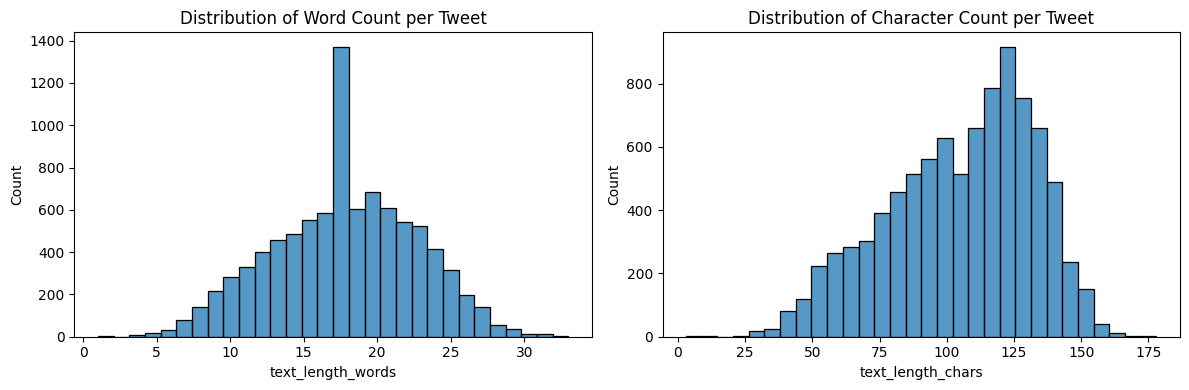

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(df['text_length_words'], bins=30)
plt.title("Distribution of Word Count per Tweet")

plt.subplot(1,2,2)
sns.histplot(df['text_length_chars'], bins=30)
plt.title("Distribution of Character Count per Tweet")

plt.tight_layout()
plt.show()

#### 2. Missing or Empty Text Detection

Identifies and removes tweets with missing or blank content to ensure data reliability.

In [9]:
# Check missing values
df['tweet_text'].isnull().sum()

# Check empty strings
df[df['tweet_text'].str.strip() == ""].shape

(0, 5)

In [11]:
#Remove missing or empty text entries
df = df[df['tweet_text'].notnull()]
df = df[df['tweet_text'].str.strip() != ""]

#### 3. Frequent Word Analysis:
Explores vocabulary patterns by identifying the most common words, helping guide text cleaning and feature extraction decisions.

In [18]:
# Simple text cleaning
def clean_text(text):
    if pd.isna(text):
        return ""                    # return empty string for NaN

    text = str(text).lower()         # ensure text is string
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df['clean_text'] = df['tweet_text'].apply(clean_text)

# Get word frequency
all_words = " ".join(df['clean_text']).split()
word_freq = Counter(all_words)

# Convert top 20 words to DataFrame
top_words = pd.DataFrame(word_freq.most_common(20), columns=['word', 'count'])
top_words

,word,count
0,sxsw,9535
1,mention,7053
2,the,4373
3,link,4284
4,to,3589
5,at,3069
6,rt,2931
7,ipad,2875
8,for,2544
9,google,2337


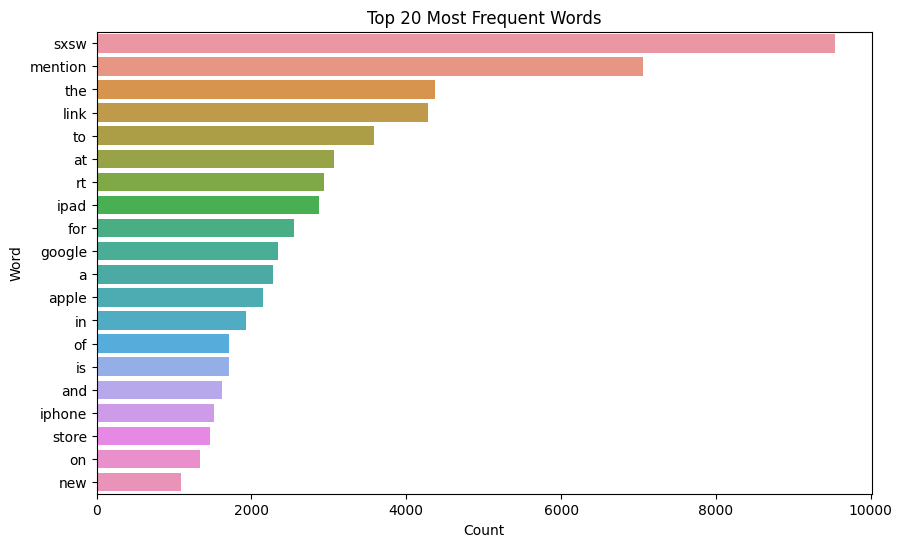

In [19]:
#Plot top 20 frequent words

plt.figure(figsize=(10,6))
sns.barplot(data=top_words, x='count', y='word')
plt.title("Top 20 Most Frequent Words")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

The visualization above highlights the most frequently occurring terms within the tweet corpus. The prominence of **“sxsw”** and **“mention”** suggests a high volume of tweets related to event discussions or user tagging. Additionally, frequent appearance of brand-related terms such as **“ipad,” “apple,” “google,”** and **“iphone”** reflects the dataset’s focus on technology products. The presence of common stopwords (**“the,” “to,” “at,” “in,”** etc.) indicates that further text preprocessing such as stopword removal may be beneficial. Overall, the distribution provides insight into dominant themes and vocabulary patterns in the dataset.

#### 4. Class Distribution Analysis:
Reviews the balance of sentiment categories (positive, negative, neutral) to anticipate modeling challenges and choose appropriate performance metrics.

In [22]:
# Count sentiment categories
sentiment_counts = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

# Display counts
sentiment_counts

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

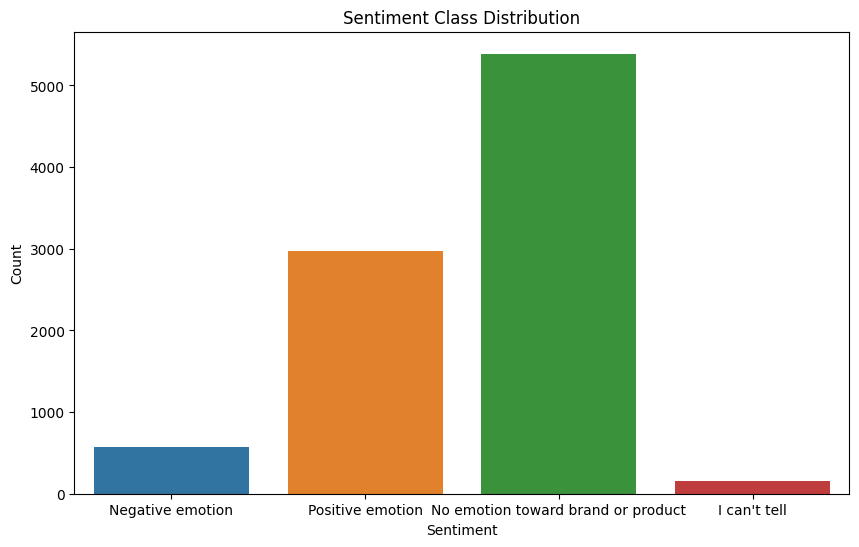

In [27]:
#Plot distribution

plt.figure(figsize=(10,6))
sns.countplot(data=df, x='is_there_an_emotion_directed_at_a_brand_or_product')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

The distribution in the graph *shown above* reveals a strong class imbalance within the dataset. The majority of tweets fall under **“No emotion toward brand or product,”** indicating that most user-generated content is neutral and does not express a clear sentiment. **Positive sentiment** represents the second-largest category, showing a notable—though much smaller—proportion of favorable reactions. **Negative sentiment** is relatively limited, suggesting fewer explicitly critical tweets. The **“I can’t tell”** category is minimal and likely has negligible impact on the modeling process.

Overall, this distribution suggests that any sentiment analysis model trained on this dataset must account for class imbalance, particularly the overwhelming dominance of neutral tweets.

Together, these steps provide a clear understanding of the dataset’s composition, highlight data quality issues, and inform decisions for the subsequent preprocessing and modeling.